In [408]:
import fiona
import pandas as pd
import geopandas as gp
import folium
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import seaborn as sns
sns.set_context('talk'); plt.style.use('ggplot')
# You need the FRAP data from https://frap.fire.ca.gov/frap-projects/fire-perimeters/

In [410]:
# Layer 0 is wildfires, layer 1 is prescribed
frame=gp.read_file("fire20_1.gdb/",layer=0)

In [411]:
# Causes
causes="""
1	Lightning
2	Equipment Use
3	Smoking
4	Campfire
5	Debris burning
6	Railroad
7	Arson
8	Playing with Fire
9	Miscellaneous
10	Vehicle
11	Power Line
12	Firefighter Training
13	Non-Firefighter Training
14	Unknown/Unidentified
15	Structure
16	Aircraft
17	Volcanic
18	Escaped Prescribed Burn
19	Illegal Alien Campfire
"""
cause_to_causename=dict([x.split("\t") for x in causes.split("\n")[1:-1]])
cause_to_causename={int(x):y for x,y in cause_to_causename.items()}

In [412]:
#Just 9 missing year from first; other 68 also missing but old fires from 1917-34 in the comments
frame=frame[(frame.YEAR_!="") &( ~frame.YEAR_.isna())].reset_index(drop=True)
#frame=frame.set_crs(crs,allow_override=True)

In [413]:
# Cleanup
#To skip 1934 and before because we know data may not be complete
frame.YEAR_=pd.to_numeric(frame.YEAR_)
frame=frame.query("YEAR_>1934")
frame.CAUSE.fillna(14,inplace=True)
frame.CAUSE=pd.to_numeric(frame.CAUSE,downcast="integer").apply(lambda x: cause_to_causename[x])
frame=frame.rename(columns={'YEAR_':'YEAR'})
# Thomas fire was caused by downed powerlines not 'misc'
frame.loc[(frame.FIRE_NAME=='THOMAS') & (frame.YEAR==2017),'CAUSE']='Power Line'
frame.loc[(frame.FIRE_NAME=='WITCH') & (frame.YEAR==2007),'CAUSE']='Power Line'

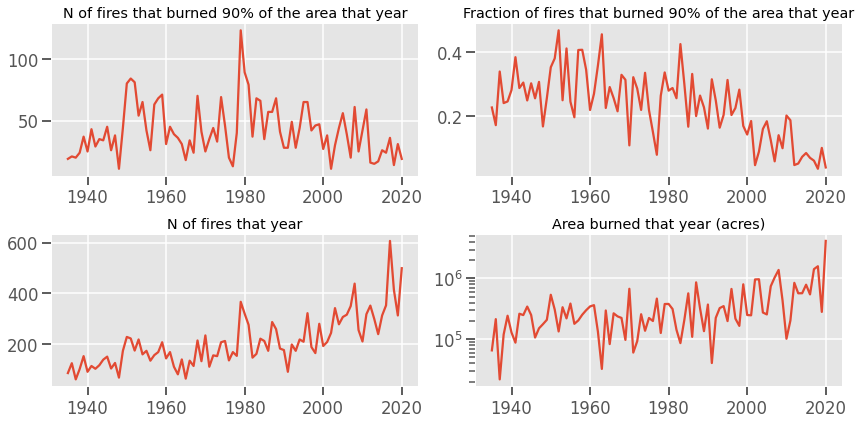

In [414]:
# Are burned top 10 fires
top_n=[]
fraction_fires=[]
fires_that_year=[]
area=[]

years=sorted(frame.YEAR.unique())
for year in years:
    t=frame.query('YEAR==@year').GIS_ACRES.dropna().sort_values(ascending=False)
    cumsummed=t.cumsum()
    prop=cumsummed.apply(lambda x: x/cumsummed.max()).reset_index(drop=True)
    n_fires=prop.sub(0.9).abs().idxmin()
    top_n.append(n_fires)
    fraction_fires.append(n_fires/len(cumsummed))
    fires_that_year.append(len(cumsummed))
    area.append(t.sum())
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(years,top_n)
plt.title('N of fires that burned 90% of the area that year')
plt.subplot(2,2,2)
plt.plot(years,fraction_fires)
plt.title('Fraction of fires that burned 90% of the area that year')
plt.subplot(2,2,3)
plt.plot(years,fires_that_year)
plt.title('N of fires that year')
plt.tight_layout()
plt.savefig('figures/fraction_fires.jpeg')
plt.subplot(2,2,4)
plt.plot(years,area)
plt.yscale("log")
plt.title('Area burned that year (acres)')
#plt.tight_layout()
plt.savefig('figures/fraction_fires.jpeg')

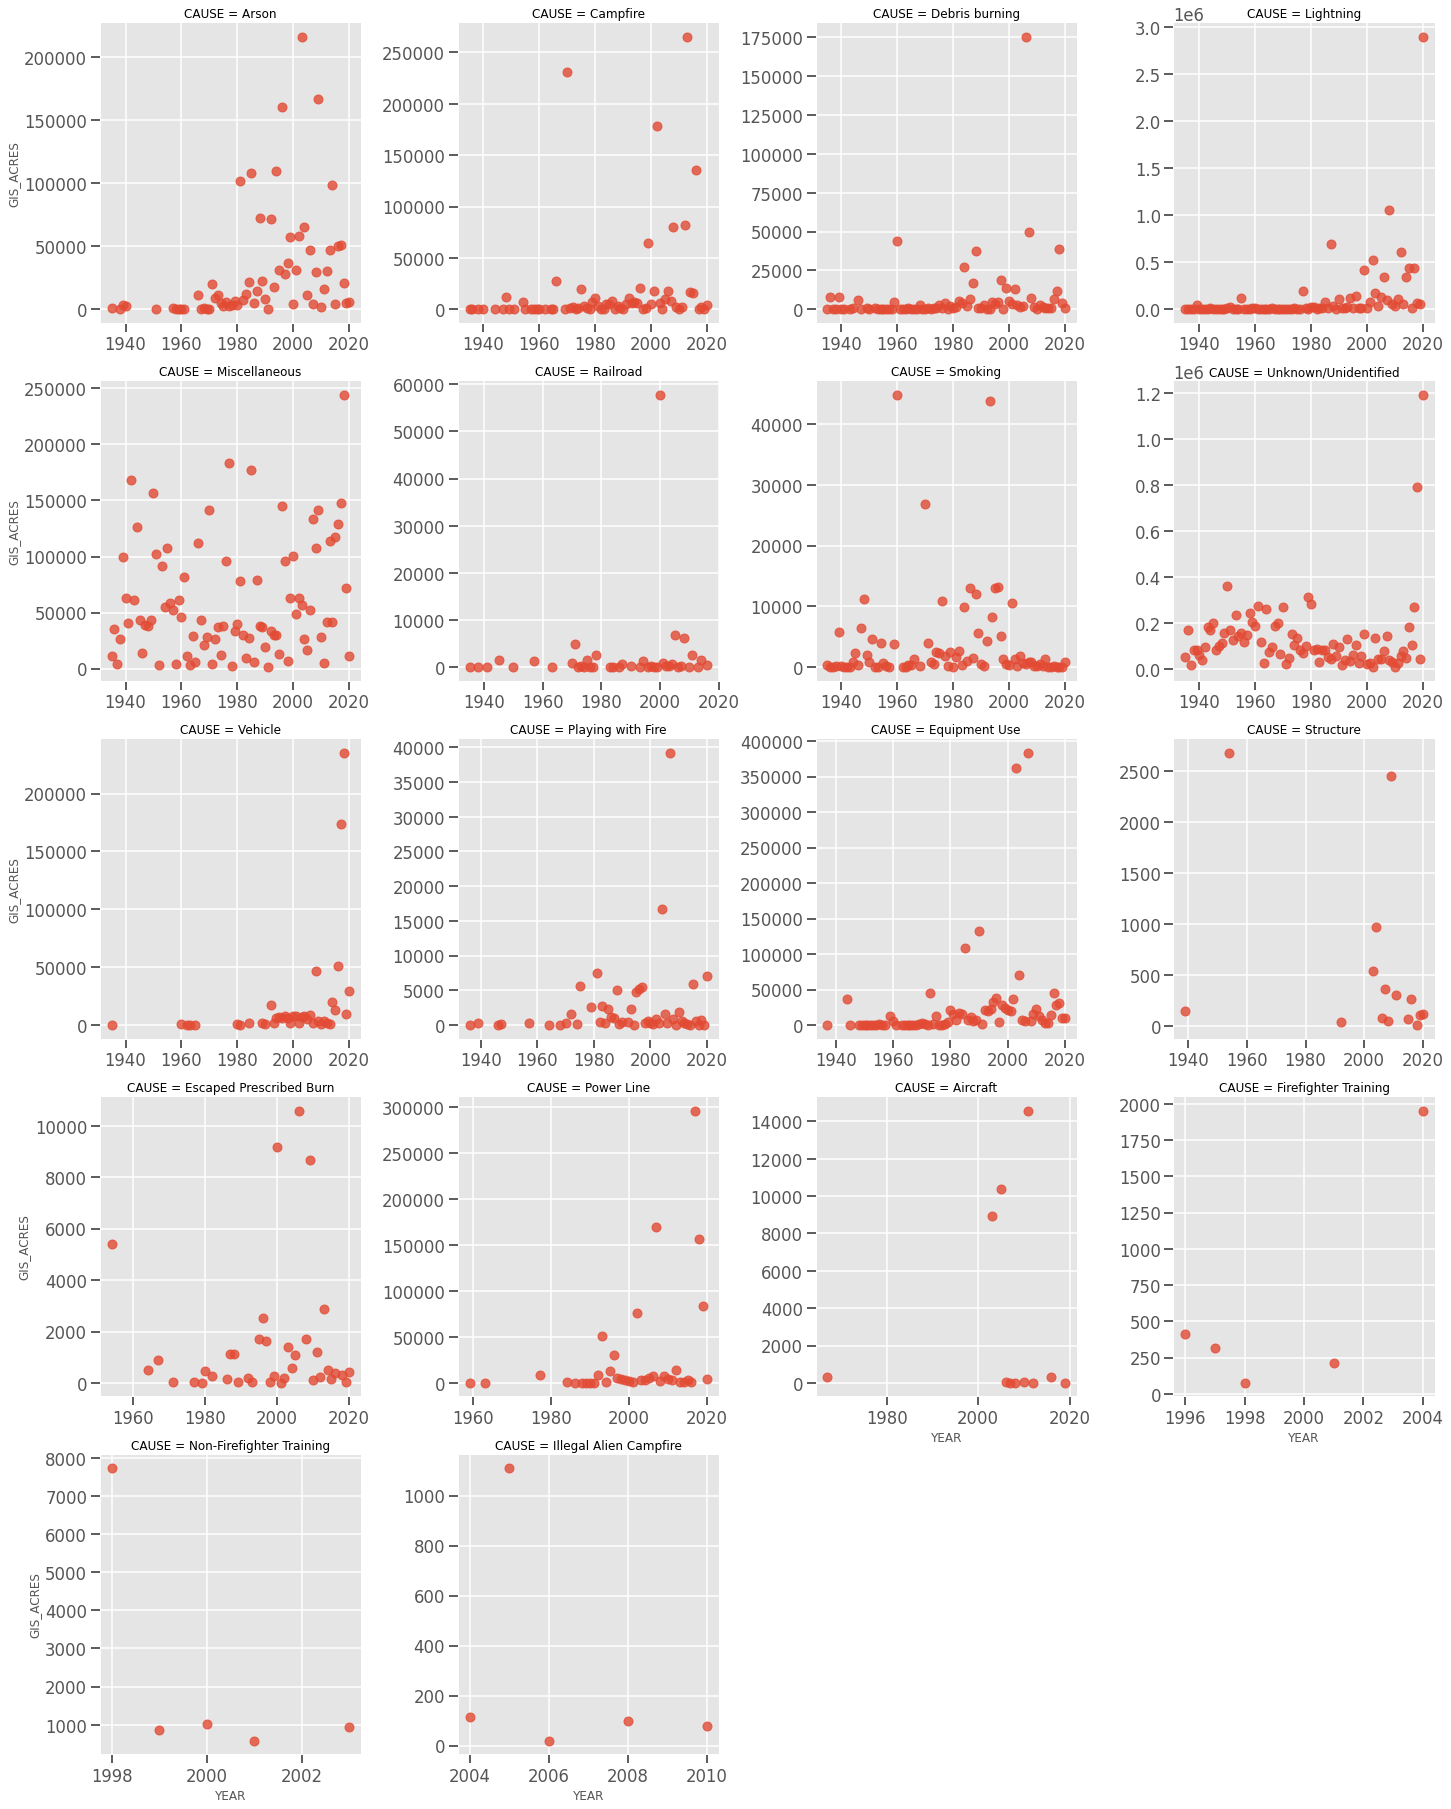

In [415]:
# What are the worse causes?
t=frame[["YEAR","CAUSE","GIS_ACRES"]]
t=t.groupby(['YEAR','CAUSE']).sum().reset_index()
#t.GIS_ACRES=np.log(t.GIS_ACRES)
sns.lmplot(x="YEAR", y="GIS_ACRES", col="CAUSE",data=t, col_wrap=4,height=5,sharey=False,sharex=False,fit_reg=False
           )
#plt.gca().set(yscale="log")
#plt.tight_layout()
plt.savefig('figures/fire_causes.jpeg')

In [416]:
t.pivot_table(columns=['CAUSE'],values='GIS_ACRES',index='YEAR').fillna(0)

CAUSE,Aircraft,Arson,Campfire,Debris burning,Equipment Use,Escaped Prescribed Burn,Firefighter Training,Illegal Alien Campfire,Lightning,Miscellaneous,Non-Firefighter Training,Playing with Fire,Power Line,Railroad,Smoking,Structure,Unknown/Unidentified,Vehicle
YEAR,,,,,,,,,,,,,,,,,,
1935,0.000000,986.598707,10.206847,134.365945,0.000000,0.000000,0.0,0.0,1.487438e+03,10916.114910,0.0,0.000000,0.000000,9.889132,319.358191,0.000000,5.136989e+04,5.576359
1936,0.000000,0.000000,2.091024,7835.037546,0.000000,0.000000,0.0,0.0,1.487279e+03,35586.165195,0.0,16.021839,0.000000,0.000000,108.988268,0.000000,1.685472e+05,0.000000
1937,0.000000,0.000000,0.000000,4.879447,54.035669,0.000000,0.0,0.0,6.070470e+02,3786.876760,0.0,0.000000,0.000000,0.000000,4.978575,0.000000,1.724172e+04,0.000000
1938,0.000000,70.076431,66.270737,99.570686,0.000000,0.000000,0.0,0.0,7.436300e+03,26666.326077,0.0,0.000000,0.000000,120.054062,161.251554,0.000000,8.458951e+04,0.000000
1939,0.000000,3485.633394,0.000000,8204.872925,0.000000,0.000000,0.0,0.0,4.324991e+04,99450.274092,0.0,268.864014,0.000000,0.000000,5828.151432,145.017960,8.265025e+04,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,338.581772,50035.172827,135373.378330,6482.004974,45143.466658,389.028992,0.0,0.0,1.862632e+04,128952.365403,0.0,570.313780,1026.542277,407.215979,144.397018,266.646088,1.070460e+05,51183.170386
2017,0.000000,50603.589251,786.288936,11528.502467,28418.906322,0.000000,0.0,0.0,4.438395e+05,148146.754199,0.0,37.487162,296072.764885,0.000000,11.932841,0.000000,2.710196e+05,174094.013597
2018,0.000000,21177.556064,2653.012529,38920.518020,30691.392596,299.900558,0.0,0.0,6.657286e+04,244193.681303,0.0,790.849060,156768.932035,0.000000,2.821170,9.179010,7.929474e+05,235403.049294


In [417]:
frame.query('YEAR>2000 & CAUSE=="Equipment Use"').sort_values('GIS_ACRES',ascending=False).head(10)

,YEAR,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry
15669,2003,CA,USF,CNF,CEDAR,00000000,2003-10-25T00:00:00+00:00,2003-11-05T00:00:00+00:00,Equipment Use,,280278.00,270686.000000,8.0,1.0,00000087,362038.176056,1.095427e+09,"MULTIPOLYGON (((297580.235 -571822.494, 297557..."
776,2007,CA,CDF,SBC,ZACA,00000020,2007-07-04T00:00:00+00:00,2007-09-02T00:00:00+00:00,Equipment Use,,240207.00,240358.703125,7.0,1.0,00000020,278821.306981,9.726971e+08,"MULTIPOLYGON (((14770.911 -360531.497, 14785.2..."
612,2007,CA,USF,PNF,MOONLIGHT,00000098,2007-09-03T00:00:00+00:00,2007-09-25T00:00:00+00:00,Equipment Use,,64995.00,64959.957031,7.0,1.0,00000098,82138.262365,2.628836e+08,"MULTIPOLYGON (((-67463.853 252638.208, -67547...."
3023,2003,CA,USF,LPF,PIRU,00000000,2003-10-23T00:00:00+00:00,2003-10-31T00:00:00+00:00,Equipment Use,,63720.00,63726.406250,8.0,1.0,00000038,99965.962475,2.578916e+08,"MULTIPOLYGON (((110119.950 -384538.943, 110246..."
502,2007,CA,USF,ANF,RANCH,00000166,2007-10-20T00:00:00+00:00,2007-11-15T00:00:00+00:00,Equipment Use,,54716.00,58410.335938,7.0,1.0,00000166,169150.715690,2.363782e+08,"MULTIPOLYGON (((114013.974 -379231.746, 114190..."
19823,2016,CA,USF,ANF,SAND,003008,2016-07-22T00:00:00+00:00,2016-08-07T00:00:00+00:00,Equipment Use,FIRESTSAT C_Meth 20 Digitized Other,41432.00,41382.859375,6.0,1.0,None,100047.282315,1.674705e+08,"MULTIPOLYGON (((147416.475 -398338.257, 147447..."
15000,2002,CA,CCO,LAC,COPPER FIRE,00112310,2002-06-05T00:00:00+00:00,2002-06-12T00:00:00+00:00,Equipment Use,,23500.00,19101.644531,7.0,1.0,00112310,80573.152191,7.730161e+07,"MULTIPOLYGON (((145463.922 -376474.310, 145471..."
9408,2004,CA,USF,ENF,POWER,00000000,2004-10-06T00:00:00+00:00,2004-10-21T00:00:00+00:00,Equipment Use,,16823.00,16983.070312,2.0,1.0,00000109,65503.699272,6.872805e+07,"MULTIPOLYGON (((-10887.930 51994.740, -10858.6..."
17262,2010,CA,CCO,LAC,CROWN,169202,2010-07-29T00:00:00+00:00,2010-08-02T00:00:00+00:00,Equipment Use,,13918.00,12582.275391,7.0,1.0,169202,82162.773680,5.091866e+07,"MULTIPOLYGON (((166763.266 -380758.390, 166765..."
519,2007,CA,CCO,KRN,WHITE,00018055,2007-06-24T00:00:00+00:00,2007-06-29T00:00:00+00:00,Equipment Use,,12432.15,12432.160156,7.0,1.0,00718055,42225.311666,5.031117e+07,"MULTIPOLYGON (((141542.676 -332160.588, 141528..."


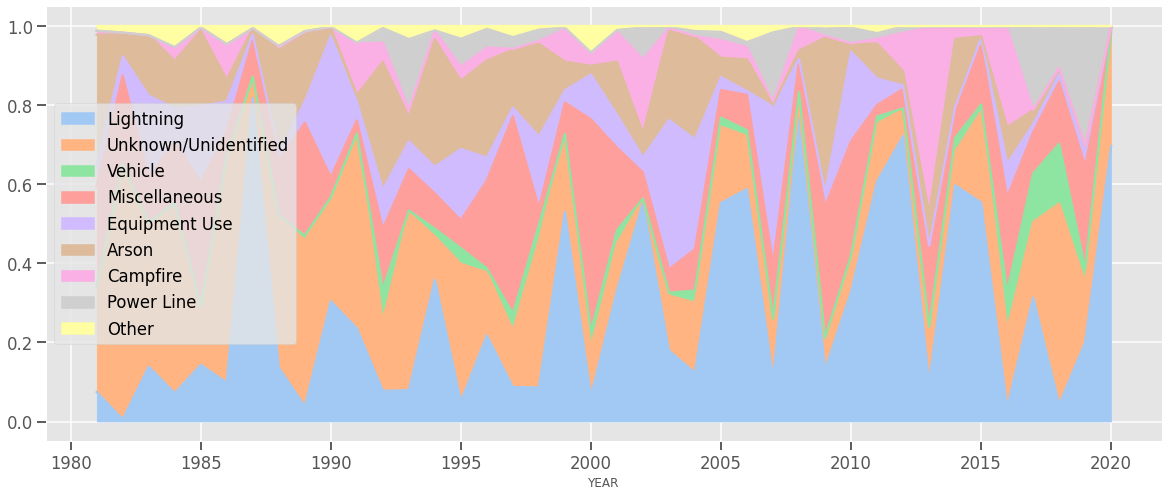

In [418]:
# What are the worse causes? It's unknown further in the past
t=frame[["YEAR","CAUSE","GIS_ACRES"]].query('YEAR>1980')
t=t.groupby(['YEAR','CAUSE']).sum().reset_index()
top_10=t.groupby('CAUSE').GIS_ACRES.sum().sort_values(ascending=False).head(8).index
t.CAUSE=t.CAUSE.apply(lambda x: x if x in top_10 else 'Other')
t=t.pivot_table(columns=['CAUSE'],values='GIS_ACRES',index='YEAR').fillna(0)
t=t.apply(lambda x: x/x.sum(),axis=1)
t=t[t.loc[2020].sort_values(ascending=False).index]
plt.figure(figsize=(20,8))
sns.set_palette("pastel")
t.plot(kind='area',stacked=True,ax=plt.gca())
sns.set_context('talk'); plt.style.use('ggplot')
plt.legend(loc='center left')
plt.savefig('figures/fire_causes_stack.jpeg')

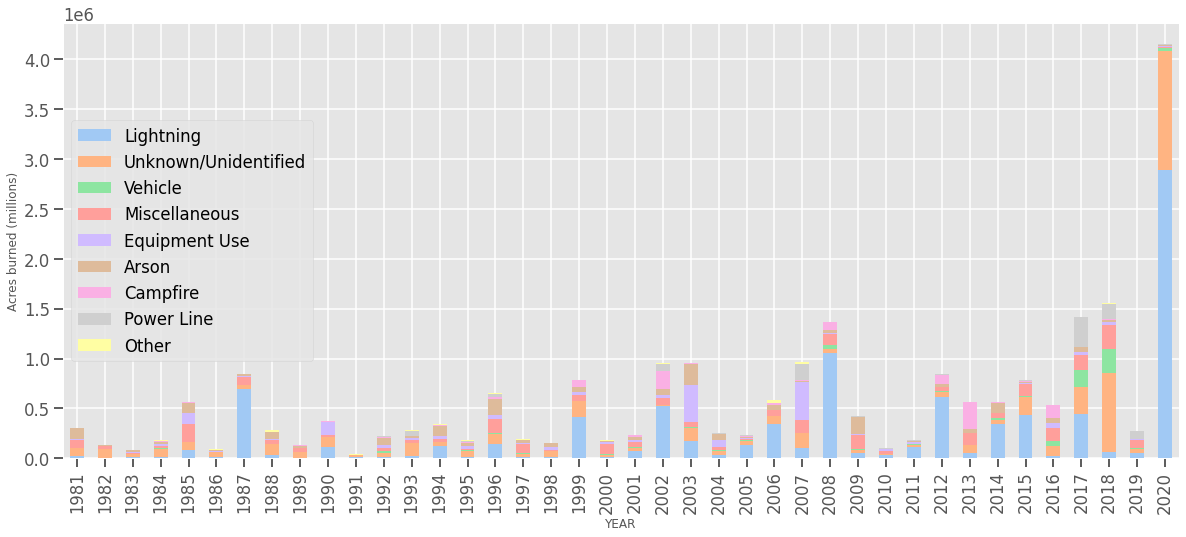

In [419]:
# What are the worse causes?
t=frame[["YEAR","CAUSE","GIS_ACRES"]].query('YEAR>1980')
t=t.groupby(['YEAR','CAUSE']).sum().reset_index()
top_10=t.groupby('CAUSE').GIS_ACRES.sum().sort_values(ascending=False).head(8).index
t.CAUSE=t.CAUSE.apply(lambda x: x if x in top_10 else 'Other')
t=t.pivot_table(columns=['CAUSE'],values='GIS_ACRES',index='YEAR').fillna(0)
t=t[t.loc[2020].sort_values(ascending=False).index]
plt.figure(figsize=(20,8))
sns.set_palette("pastel")
t.plot(kind='bar',stacked=True,ax=plt.gca())
sns.set_context('talk'); plt.style.use('ggplot')
plt.legend(loc='center left')
plt.ylabel('Acres burned (millions)')
plt.savefig('figures/acres_burned_stack.jpeg')

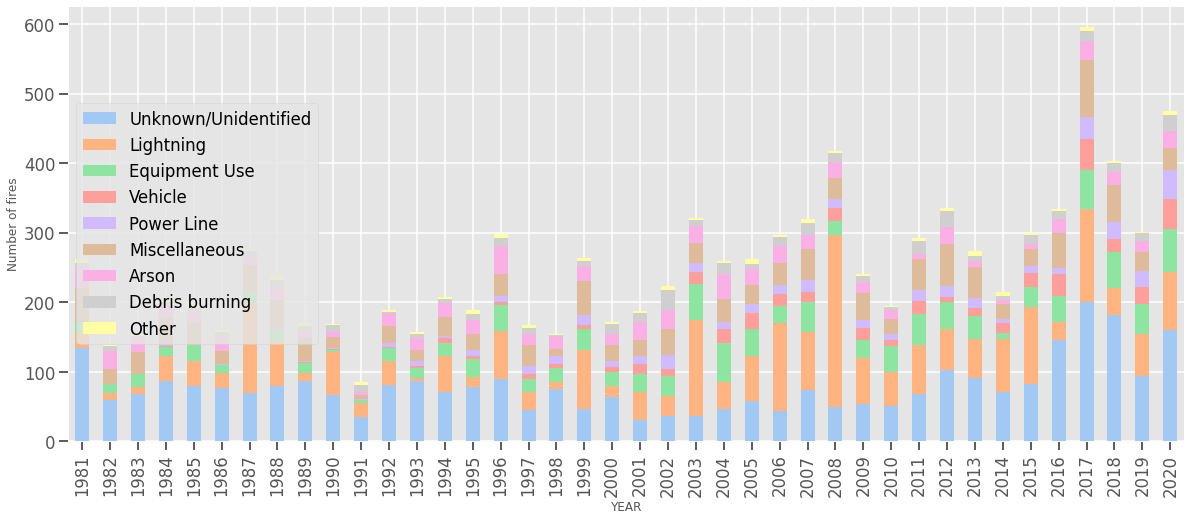

In [420]:
# Numerically, how many fires of each type?
t=frame[["YEAR","CAUSE","GIS_ACRES"]].query('YEAR>1980')
t=t.groupby(['YEAR','CAUSE']).count().reset_index()
top_10=t.groupby('CAUSE').GIS_ACRES.sum().sort_values(ascending=False).head(8).index
t.CAUSE=t.CAUSE.apply(lambda x: x if x in top_10 else 'Other')
t=t.pivot_table(columns=['CAUSE'],values='GIS_ACRES',index='YEAR').fillna(0)
t=t[t.loc[2020].sort_values(ascending=False).index]
plt.figure(figsize=(20,8))
sns.set_palette("pastel")
t.plot(kind='bar',stacked=True,ax=plt.gca())
sns.set_context('talk'); plt.style.use('ggplot')
plt.legend(loc='center left')
plt.ylabel('Number of fires')
plt.savefig('figures/number_fires_stack.jpeg')

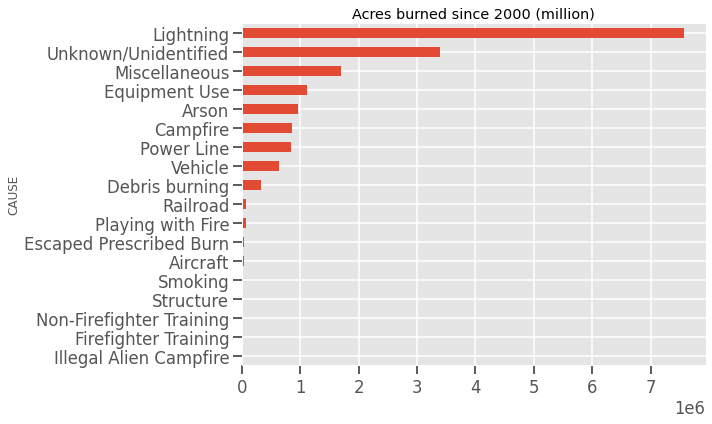

In [421]:
t=frame[["YEAR","CAUSE","GIS_ACRES"]].query('YEAR>=2000')
t=t.groupby(['YEAR','CAUSE']).sum().reset_index()
plt.figure(figsize=(10,6))
t.groupby('CAUSE').GIS_ACRES.sum().sort_values(ascending=True).plot(kind='barh')
plt.title('Acres burned since 2000 (million)')
plt.tight_layout()
plt.savefig('figures/causes_summed.jpeg')

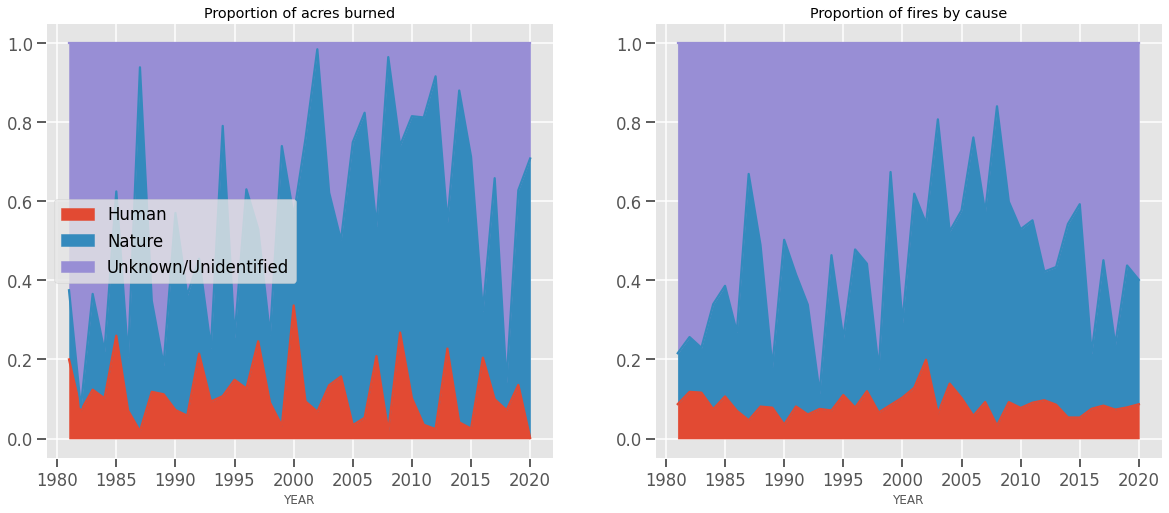

In [422]:
# Human vs non-human
def renamer(x):
    if x=='Lightning':
        return 'Nature'
    if x=='Unknown/Unidentified':
        return x
    else:
        return 'Human'
t=frame[["YEAR","CAUSE","GIS_ACRES"]].query('YEAR>1980')
t=t.groupby(['YEAR','CAUSE']).sum().reset_index()
t.CAUSE=t.CAUSE.apply(renamer)
t=t.pivot_table(columns=['CAUSE'],values='GIS_ACRES',index='YEAR').fillna(0)
t=t.apply(lambda x: x/x.sum(),axis=1)
t=t[['Human','Nature','Unknown/Unidentified']]
sns.set_context('talk'); plt.style.use('ggplot')
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
t.plot(kind='area',stacked=True,ax=plt.gca())

plt.legend(loc='center left')
plt.title('Proportion of acres burned')

plt.subplot(1,2,2)
t=frame[["YEAR","CAUSE","GIS_ACRES"]].query('YEAR>1980')
t=t.groupby(['YEAR','CAUSE']).count().reset_index()
t.CAUSE=t.CAUSE.apply(renamer)
t=t.pivot_table(columns=['CAUSE'],values='GIS_ACRES',index='YEAR').fillna(0)
t=t.apply(lambda x: x/x.sum(),axis=1)
t=t[['Human','Nature','Unknown/Unidentified']]
t.plot(kind='area',stacked=True,ax=plt.gca(),legend=None)
plt.title('Proportion of fires by cause')

plt.savefig('figures/human_vs_nature.jpeg')

In [461]:
t

,geometry
CAUSE,
Human,"MULTIPOLYGON (((-116.03153 32.63879, -116.0315..."
Nature,"MULTIPOLYGON (((-116.79004 33.67689, -116.7904..."
Unknown/Unidentified,"MULTIPOLYGON (((-116.79633 32.56519, -116.7965..."


In [465]:
t

,geometry,CAUSE
0,"MULTIPOLYGON (((-121.34840 38.88999, -121.3483...",Human
1,"MULTIPOLYGON (((-121.35275 38.82038, -121.3526...",Human
2,"MULTIPOLYGON (((-121.33333 38.84558, -121.3331...",Unknown/Unidentified
3,"MULTIPOLYGON (((-121.27317 38.96308, -121.2730...",Human
4,"MULTIPOLYGON (((-121.30065 39.48714, -121.3004...",Human
...,...,...
495,"MULTIPOLYGON (((-121.70427 40.03537, -121.7034...",Nature
496,"MULTIPOLYGON (((-121.67118 40.04473, -121.6713...",Nature
497,"MULTIPOLYGON (((-121.55705 40.00003, -121.5562...",Nature
498,"MULTIPOLYGON (((-121.58284 40.02776, -121.5829...",Nature


In [481]:
geo_j.control

True

In [567]:
def renamer(x):
    if x=='Lightning':
        return 'Nature'
    if x=='Unknown/Unidentified':
        return x
    else:
        return 'Human'
def color_fn(x):
    if x['properties']['CAUSE']=='Human':
        return 'red'
    if x['properties']['CAUSE']=='Nature':
        return 'green'
    else:
        return 'blue'
t=frame.assign(FIRE_NAME=lambda x: x.FIRE_NAME+" "+x.YEAR.astype(str)).query('YEAR>2005')[["geometry","CAUSE","YEAR","FIRE_NAME"]]
t.CAUSE=t.CAUSE.apply(renamer)
# To plot all the data (but fucks popups)
#t=t.dissolve(by='CAUSE').reset_index()
t=t.to_crs('EPSG:4326')
# Stamen Terrain
map = folium.Map( zoom_start = 9,location=[39.6282678, -122.8487696 ],tiles="Stamen Toner",control=True,width=900,height=600)
opacity=0.2

for idx,row in t.iterrows():
    geo_j = gp.GeoDataFrame(row).T.to_json()
    geo_j = folium.GeoJson(data=geo_j,name=row['CAUSE'],
                       style_function=lambda x: {'fillColor': color_fn(x),'color':color_fn(x),'fillOpacity':opacity},
                     )
    folium.Popup(row['FIRE_NAME']).add_to(geo_j)
    geo_j.overlay

    geo_j.add_to(map)
folium.LayerControl().add_to(map)
#map

AttributeError: 'GeoDataFrame' object has no attribute 'FIRE_NAME'

In [562]:
# Prescribed fire
# Layer 0 is wildfires, layer 1 is prescribed
frame=gp.read_file("fire20_1.gdb/",layer=1)

In [563]:
# Cleanup
frame=frame[frame.YEAR_.notna()&(frame.YEAR_!=" ")]
frame.YEAR_=pd.to_numeric(frame.YEAR_)
frame=frame
frame=frame.rename(columns={'YEAR_':'YEAR'})

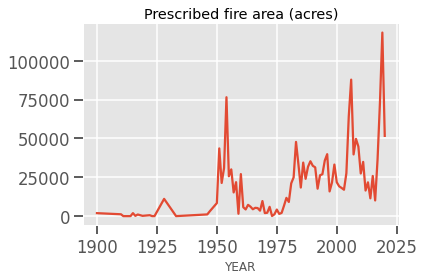

In [564]:
frame.groupby('YEAR').GIS_ACRES.sum().plot()
plt.title('Prescribed fire area (acres)')
plt.tight_layout()
plt.savefig('figures/prescribed_total.jpeg')

In [566]:
frame.groupby('YEAR').GIS_ACRES.sum().sort_values()

YEAR
1913.0         2.987360
1912.0         4.978284
1911.0         4.978435
1933.0         7.965947
1914.0        11.948680
              ...      
2005.0     64305.016090
2018.0     73117.719455
1954.0     76552.946785
2006.0     87881.973384
2019.0    118186.498219
Name: GIS_ACRES, Length: 88, dtype: float64